In [1]:
from pytorch_lightning import utilities as pl_utils
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.plugins import DDPPlugin
import torch
import pathlib
from functools import partial
import sys, glob
import numpy as np

sys.path.append('..')
sys.path.append('../deep-learning-base')
sys.path.append('../partially_inverted_reps')

import plot_helper as plt_hp
import output as out
from training import LitProgressBar, NicerModelCheckpointing
import training.finetuning as ft
import architectures as arch
from architectures.callbacks import LightningWrapper, LinearEvalWrapper
from attack.callbacks import AdvCallback
from datasets.data_modules import DATA_MODULES
import datasets.dataset_metadata as dsmd
from partial_loss import PartialInversionLoss, PartialInversionRegularizedLoss
from __init__ import DATA_PATH_IMAGENET, DATA_PATH, SERVER_PROJECT_PATH

/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
CHECKPOINT_PATHS = {
    'nonrob': '',
    'robustl2eps3': '/NS/robustness_2/work/vnanda/adv-robustness/logs/robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'
}

In [3]:
SEED = 2
NUM_NODES = 1
DEVICES = 1
BASE_DIR = f"{pathlib.Path('.').parent.resolve()}/checkpoints"

SOURCE_DATASET = 'imagenet'
APPENDS = ['robustl2eps3', 'nonrob']
FINETUNING_DATASETS = ['cifar10', 'cifar100', 'flowers', 'oxford-iiit-pets']
FINETUNE_MODE = 'random'
MODEL = 'resnet50'
FINETUNE_BS = 256
EVAL_BATCH_SIZE = 100

PARTIAL_CHOICE_SEEDS = list(range(1,6))
PARTIAL_FRACTIONS = [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.]

In [4]:
def get_test_acc(finetuning_dataset, checkpoint_path, state_dict, seed, fraction):
    dm = DATA_MODULES[finetuning_dataset](
        data_dir=DATA_PATH_IMAGENET if 'imagenet' in finetuning_dataset else DATA_PATH,
        transform_train=dsmd.TRAIN_TRANSFORMS_TRANSFER_DEFAULT(224),
        transform_test=dsmd.TEST_TRANSFORMS_DEFAULT(224),
        batch_size=EVAL_BATCH_SIZE)
    dm.init_remaining_attrs(SOURCE_DATASET)

    ## assign mean and std from source dataset
    m1 = arch.create_model(MODEL, SOURCE_DATASET, pretrained=True,
                           checkpoint_path=checkpoint_path, seed=SEED, 
                           callback=partial(LightningWrapper, 
                                            dataset_name=SOURCE_DATASET,
                                            inference_kwargs={'with_latent': True}))
    new_layer = ft.setup_model_for_finetuning(
        m1.model, 
        dsmd.DATASET_PARAMS[finetuning_dataset]['num_classes'],
        FINETUNE_MODE, fraction, seed)
    print (new_layer.__dict__)
    linear_layer = list(m1.model.named_modules())[-1][1]
    linear_layer.load_state_dict({k.split('.')[-1]:v \
                                  for k,v in state_dict['state_dict'].items()}, strict=True)
    if hasattr(new_layer, 'neuron_indices') and 'neuron_indices' in state_dict:
        assert torch.all(new_layer.neuron_indices == state_dict['neuron_indices'])
    pl_utils.seed.seed_everything(seed, workers=True)

    trainer = Trainer(accelerator='gpu', 
                      devices=DEVICES,
                      num_nodes=NUM_NODES,
                      log_every_n_steps=1,
                      auto_select_gpus=True, 
                      deterministic=True,
                      check_val_every_n_epoch=1,
                      num_sanity_val_steps=0,
                      callbacks=[
                        LitProgressBar(['loss', 
                                        'running_test_acc'])])

    out = trainer.predict(m1, dataloaders=[dm.test_dataloader()])
    if trainer.is_global_zero:
        ## do things on the main process
        gt = out[2]
        pred = torch.argmax(out[0], 1)
        return torch.sum(gt == pred) / len(gt)

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'neuron_indices': tensor([1061])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ..., 1196,  674,  997])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ...,  522, 1270,  719])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ..., 1357, 1453, 1455])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'neuron_indices': tensor([1192])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2048, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ...,  637, 1922, 1063])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

../plot_helper.py:110: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  label=legend_vals[i] if legend_vals is not None else "")


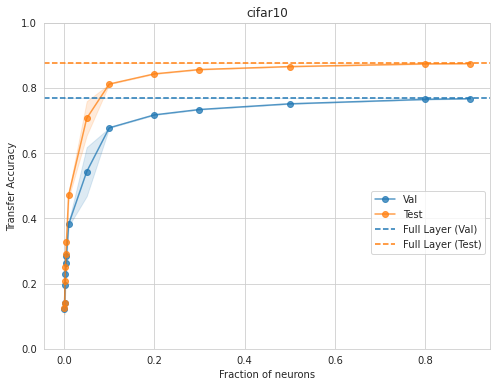

Global seed set to 2


cifar10 {0.0005: [0.1265285313129425, 0.11961649358272552], 0.001: [0.14361095428466797, 0.13518540561199188], 0.002: [0.2291000336408615, 0.1645336002111435], 0.003: [0.2579345703125, 0.2001740038394928], 0.004: [0.2836717963218689, 0.24395880103111267], 0.005: [0.2949533462524414, 0.27139902114868164], 0.01: [0.3885359764099121, 0.37577682733535767], 0.05: [0.6182283163070679, 0.4678797125816345], 0.1: [0.6775320172309875], 0.2: [0.7172002196311951], 0.3: [0.7336753606796265], 0.5: [0.7511133551597595], 0.8: [0.7646709680557251], 0.9: [0.7667981386184692]}


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'neuron_indices': tensor([1061])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ..., 1196,  674,  997])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ...,  522, 1270,  719])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ..., 1357, 1453, 1455])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'neuron_indices': tensor([1192])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=100, bias=True))]), 'neuron_indices': tensor([1192, 1790])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=100, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=100, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=100, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=100, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=100, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=100, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=100, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=100, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=100, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=100, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ..., 1646,  183,  570])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2048, out_features=100, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ...,  637, 1922, 1063])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

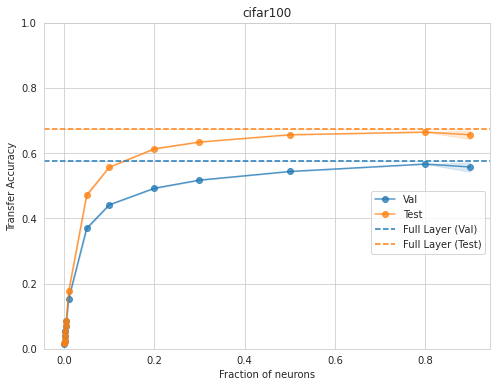

Global seed set to 2


cifar100 {0.0005: [0.016172125935554504, 0.015453372150659561], 0.001: [0.020859677344560623, 0.02661735564470291], 0.002: [0.03521612286567688, 0.042476702481508255], 0.003: [0.051436617970466614, 0.05589158833026886], 0.004: [0.06971809267997742, 0.06995562463998795], 0.005: [0.08689111471176147, 0.086604043841362], 0.01: [0.1501409113407135, 0.15524908900260925], 0.05: [0.37309718132019043, 0.36608925461769104], 0.1: [0.44078660011291504, 0.44210606813430786], 0.2: [0.4912300705909729, 0.4933592975139618], 0.3: [0.5166686773300171, 0.5177937746047974], 0.5: [0.5436294078826904], 0.8: [0.566443920135498], 0.9: [0.5717778205871582, 0.5430242419242859]}


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([1061])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ..., 1196,  674,  997])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ...,  522, 1270,  719])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ..., 1357, 1453, 1455])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([1192])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ...,  991,  983,  856])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ...,  662, 1879,  760])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ..., 1646,  183,  570])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2048, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ...,  637, 1922, 1063])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([1898])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848, 1760, 1483, 2047, 1104,
         592, 1511, 1945,  473, 1382, 1750,  580,  829, 1980, 1926, 1035, 1447,
        1781, 1141,  220, 1730, 1501, 1652,  438,  563,  462,  410,  794, 1756,
        1745, 1387, 1213,  658,  317, 1187,  418, 1526, 1973, 1117,  954,  325,
        1524,  668,   55, 1475,  320, 1440, 1544, 1011,  831, 1651,  332,  457,
          79,  290,  943, 1805, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848, 1760, 1483, 2047, 1104,
         592, 1511, 1945,  473, 1382, 1750,  580,  829, 1980, 1926, 1035, 1447,
        1781, 1141,  220, 1730, 1501, 1652,  438,  563,  462,  410,  794, 1756,
        1745, 1387, 1213,  658,  317, 1187,  418, 1526, 1973, 1117,  954,  325,
        1524,  668,   55, 1475,  320, 1440, 1544, 1011,  831, 1651,  332,  457,
          79,  290,  943, 1805, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848, 1760, 1483, 2047, 1104,
         592, 1511, 1945,  473, 1382, 1750,  580,  829, 1980, 1926, 1035, 1447,
        1781, 1141,  220, 1730, 1501, 1652,  438,  563,  462,  410,  794, 1756,
        1745, 1387, 1213,  658,  317, 1187,  418, 1526, 1973, 1117,  954,  325,
        1524,  668,   55, 1475,  320, 1440, 1544, 1011,  831, 1651,  332,  457,
          79,  290,  943, 1805, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848, 1760, 1483, 2047, 1104,
         592, 1511, 1945,  473, 1382, 1750,  580,  829, 1980, 1926, 1035, 1447,
        1781, 1141,  220, 1730, 1501, 1652,  438,  563,  462,  410,  794, 1756,
        1745, 1387, 1213,  658,  317, 1187,  418, 1526, 1973, 1117,  954,  325,
        1524,  668,   55, 1475,  320, 1440, 1544, 1011,  831, 1651,  332,  457,
          79,  290,  943, 1805, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669,  ...,  508, 1269, 1685])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669,  ...,  452,  466, 1714])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669,  ..., 1624, 1083,   66])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([1146])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181, 1314, 1264,  938, 1662,
         834,  926,  859, 1417, 1827,  540, 1983,  948,  710,  410, 1672, 1043,
         818, 1198, 1493, 1802,  544, 1698, 1638, 1327, 1699, 1633, 1280, 1218,
        1866, 1828, 2001,  337, 1098, 1331, 1902,  170, 1850,  599,  405, 1739,
        1411, 1458, 1925, 1115, 1745,   42, 1277, 1310,  709,  273, 2008, 1637,
         311,  290,  832,  785, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181, 1314, 1264,  938, 1662,
         834,  926,  859, 1417, 1827,  540, 1983,  948,  710,  410, 1672, 1043,
         818, 1198, 1493, 1802,  544, 1698, 1638, 1327, 1699, 1633, 1280, 1218,
        1866, 1828, 2001,  337, 1098, 1331, 1902,  170, 1850,  599,  405, 1739,
        1411, 1458, 1925, 1115, 1745,   42, 1277, 1310,  709,  273, 2008, 1637,
         311,  290,  832,  785, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181, 1314, 1264,  938, 1662,
         834,  926,  859, 1417, 1827,  540, 1983,  948,  710,  410, 1672, 1043,
         818, 1198, 1493, 1802,  544, 1698, 1638, 1327, 1699, 1633, 1280, 1218,
        1866, 1828, 2001,  337, 1098, 1331, 1902,  170, 1850,  599,  405, 1739,
        1411, 1458, 1925, 1115, 1745,   42, 1277, 1310,  709,  273, 2008, 1637,
         311,  290,  832,  785, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181, 1314, 1264,  938, 1662,
         834,  926,  859, 1417, 1827,  540, 1983,  948,  710,  410, 1672, 1043,
         818, 1198, 1493, 1802,  544, 1698, 1638, 1327, 1699, 1633, 1280, 1218,
        1866, 1828, 2001,  337, 1098, 1331, 1902,  170, 1850,  599,  405, 1739,
        1411, 1458, 1925, 1115, 1745,   42, 1277, 1310,  709,  273, 2008, 1637,
         311,  290,  832,  785, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87,  ...,  704,  766, 1596])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87,  ...,  231, 1078,  854])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87,  ...,  643, 1368, 1454])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([867])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530, 1241, 1320, 1572,  932,
        1524, 1775, 1821,  515, 2011,  791,  206, 1714, 1885,  942, 1980,  629,
         437, 1519,  493,  977,  686, 1081, 1672, 1725,   52,  642, 1011, 1405,
           6,  936,  782,  144, 1300, 1072, 1671,  498, 1239, 1709, 1314, 1551,
          97, 1795,  705, 1578, 1841,  475, 1251,  423, 1844, 1635,  190,  537,
         795,  589,  335,  259, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530, 1241, 1320, 1572,  932,
        1524, 1775, 1821,  515, 2011,  791,  206, 1714, 1885,  942, 1980,  629,
         437, 1519,  493,  977,  686, 1081, 1672, 1725,   52,  642, 1011, 1405,
           6,  936,  782,  144, 1300, 1072, 1671,  498, 1239, 1709, 1314, 1551,
          97, 1795,  705, 1578, 1841,  475, 1251,  423, 1844, 1635,  190,  537,
         795,  589,  335,  259, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530, 1241, 1320, 1572,  932,
        1524, 1775, 1821,  515, 2011,  791,  206, 1714, 1885,  942, 1980,  629,
         437, 1519,  493,  977,  686, 1081, 1672, 1725,   52,  642, 1011, 1405,
           6,  936,  782,  144, 1300, 1072, 1671,  498, 1239, 1709, 1314, 1551,
          97, 1795,  705, 1578, 1841,  475, 1251,  423, 1844, 1635,  190,  537,
         795,  589,  335,  259, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530, 1241, 1320, 1572,  932,
        1524, 1775, 1821,  515, 2011,  791,  206, 1714, 1885,  942, 1980,  629,
         437, 1519,  493,  977,  686, 1081, 1672, 1725,   52,  642, 1011, 1405,
           6,  936,  782,  144, 1300, 1072, 1671,  498, 1239, 1709, 1314, 1551,
          97, 1795,  705, 1578, 1841,  475, 1251,  423, 1844, 1635,  190,  537,
         795,  589,  335,  259, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  ...,  459, 2016,  221])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  ..., 1362,  875, 1374])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  ..., 1000,  284,  776])}


Predicting: 0it [00:00, ?it/s]

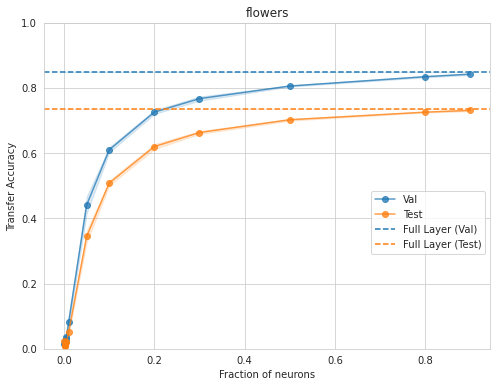

Global seed set to 2


flowers {0.0005: [0.009830985218286514, 0.01665923371911049, 0.014221671968698502, 0.013718011789023876, 0.015674980357289314], 0.001: [0.013698788359761238, 0.012257013469934464, 0.014187069609761238, 0.015205923467874527, 0.018604669719934464], 0.002: [0.014221671968698502, 0.01963505893945694, 0.017185963690280914, 0.017616571858525276, 0.012756828218698502], 0.003: [0.017612727358937263, 0.022510919719934464, 0.021061453968286514, 0.022038016468286514, 0.026432547718286514], 0.004: [0.0274360254406929, 0.03771299868822098, 0.028950847685337067, 0.024483267217874527, 0.03869340568780899], 0.005: [0.03526005893945694, 0.03529081493616104, 0.046559736132621765, 0.019573543220758438, 0.043583907186985016], 0.01: [0.0711045116186142, 0.08043568581342697, 0.0759565681219101, 0.07838644087314606, 0.10443836450576782], 0.05: [0.4238819479942322, 0.4023206830024719, 0.4704263210296631, 0.46700066328048706, 0.44304412603378296], 0.1: [0.5974985957145691, 0.6043345332145691, 0.613073587417602

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([1061])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ..., 1196,  674,  997])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ...,  522, 1270,  719])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ..., 1357, 1453, 1455])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([1192])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ...,  991,  983,  856])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ...,  662, 1879,  760])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ..., 1646,  183,  570])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2048, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ...,  637, 1922, 1063])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([1898])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848, 1760, 1483, 2047, 1104,
         592, 1511, 1945,  473, 1382, 1750,  580,  829, 1980, 1926, 1035, 1447,
        1781, 1141,  220, 1730, 1501, 1652,  438,  563,  462,  410,  794, 1756,
        1745, 1387, 1213,  658,  317, 1187,  418, 1526, 1973, 1117,  954,  325,
        1524,  668,   55, 1475,  320, 1440, 1544, 1011,  831, 1651,  332,  457,
          79,  290,  943, 1805,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848, 1760, 1483, 2047, 1104,
         592, 1511, 1945,  473, 1382, 1750,  580,  829, 1980, 1926, 1035, 1447,
        1781, 1141,  220, 1730, 1501, 1652,  438,  563,  462,  410,  794, 1756,
        1745, 1387, 1213,  658,  317, 1187,  418, 1526, 1973, 1117,  954,  325,
        1524,  668,   55, 1475,  320, 1440, 1544, 1011,  831, 1651,  332,  457,
          79,  290,  943, 1805,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848, 1760, 1483, 2047, 1104,
         592, 1511, 1945,  473, 1382, 1750,  580,  829, 1980, 1926, 1035, 1447,
        1781, 1141,  220, 1730, 1501, 1652,  438,  563,  462,  410,  794, 1756,
        1745, 1387, 1213,  658,  317, 1187,  418, 1526, 1973, 1117,  954,  325,
        1524,  668,   55, 1475,  320, 1440, 1544, 1011,  831, 1651,  332,  457,
          79,  290,  943, 1805,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848, 1760, 1483, 2047, 1104,
         592, 1511, 1945,  473, 1382, 1750,  580,  829, 1980, 1926, 1035, 1447,
        1781, 1141,  220, 1730, 1501, 1652,  438,  563,  462,  410,  794, 1756,
        1745, 1387, 1213,  658,  317, 1187,  418, 1526, 1973, 1117,  954,  325,
        1524,  668,   55, 1475,  320, 1440, 1544, 1011,  831, 1651,  332,  457,
          79,  290,  943, 1805,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669,  ...,  508, 1269, 1685])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669,  ...,  452,  466, 1714])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669,  ..., 1624, 1083,   66])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([1146])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181, 1314, 1264,  938, 1662,
         834,  926,  859, 1417, 1827,  540, 1983,  948,  710,  410, 1672, 1043,
         818, 1198, 1493, 1802,  544, 1698, 1638, 1327, 1699, 1633, 1280, 1218,
        1866, 1828, 2001,  337, 1098, 1331, 1902,  170, 1850,  599,  405, 1739,
        1411, 1458, 1925, 1115, 1745,   42, 1277, 1310,  709,  273, 2008, 1637,
         311,  290,  832,  785,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181, 1314, 1264,  938, 1662,
         834,  926,  859, 1417, 1827,  540, 1983,  948,  710,  410, 1672, 1043,
         818, 1198, 1493, 1802,  544, 1698, 1638, 1327, 1699, 1633, 1280, 1218,
        1866, 1828, 2001,  337, 1098, 1331, 1902,  170, 1850,  599,  405, 1739,
        1411, 1458, 1925, 1115, 1745,   42, 1277, 1310,  709,  273, 2008, 1637,
         311,  290,  832,  785,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181, 1314, 1264,  938, 1662,
         834,  926,  859, 1417, 1827,  540, 1983,  948,  710,  410, 1672, 1043,
         818, 1198, 1493, 1802,  544, 1698, 1638, 1327, 1699, 1633, 1280, 1218,
        1866, 1828, 2001,  337, 1098, 1331, 1902,  170, 1850,  599,  405, 1739,
        1411, 1458, 1925, 1115, 1745,   42, 1277, 1310,  709,  273, 2008, 1637,
         311,  290,  832,  785,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181, 1314, 1264,  938, 1662,
         834,  926,  859, 1417, 1827,  540, 1983,  948,  710,  410, 1672, 1043,
         818, 1198, 1493, 1802,  544, 1698, 1638, 1327, 1699, 1633, 1280, 1218,
        1866, 1828, 2001,  337, 1098, 1331, 1902,  170, 1850,  599,  405, 1739,
        1411, 1458, 1925, 1115, 1745,   42, 1277, 1310,  709,  273, 2008, 1637,
         311,  290,  832,  785,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87,  ...,  704,  766, 1596])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87,  ...,  231, 1078,  854])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87,  ...,  643, 1368, 1454])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([867])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530, 1241, 1320, 1572,  932,
        1524, 1775, 1821,  515, 2011,  791,  206, 1714, 1885,  942, 1980,  629,
         437, 1519,  493,  977,  686, 1081, 1672, 1725,   52,  642, 1011, 1405,
           6,  936,  782,  144, 1300, 1072, 1671,  498, 1239, 1709, 1314, 1551,
          97, 1795,  705, 1578, 1841,  475, 1251,  423, 1844, 1635,  190,  537,
         795,  589,  335,  259,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530, 1241, 1320, 1572,  932,
        1524, 1775, 1821,  515, 2011,  791,  206, 1714, 1885,  942, 1980,  629,
         437, 1519,  493,  977,  686, 1081, 1672, 1725,   52,  642, 1011, 1405,
           6,  936,  782,  144, 1300, 1072, 1671,  498, 1239, 1709, 1314, 1551,
          97, 1795,  705, 1578, 1841,  475, 1251,  423, 1844, 1635,  190,  537,
         795,  589,  335,  259,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530, 1241, 1320, 1572,  932,
        1524, 1775, 1821,  515, 2011,  791,  206, 1714, 1885,  942, 1980,  629,
         437, 1519,  493,  977,  686, 1081, 1672, 1725,   52,  642, 1011, 1405,
           6,  936,  782,  144, 1300, 1072, 1671,  498, 1239, 1709, 1314, 1551,
          97, 1795,  705, 1578, 1841,  475, 1251,  423, 1844, 1635,  190,  537,
         795,  589,  335,  259,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530, 1241, 1320, 1572,  932,
        1524, 1775, 1821,  515, 2011,  791,  206, 1714, 1885,  942, 1980,  629,
         437, 1519,  493,  977,  686, 1081, 1672, 1725,   52,  642, 1011, 1405,
           6,  936,  782,  144, 1300, 1072, 1671,  498, 1239, 1709, 1314, 1551,
          97, 1795,  705, 1578, 1841,  475, 1251,  423, 1844, 1635,  190,  537,
         795,  589,  335,  259,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  ...,  459, 2016,  221])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  ..., 1362,  875, 1374])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  ..., 1000,  284,  776])}


Predicting: 0it [00:00, ?it/s]

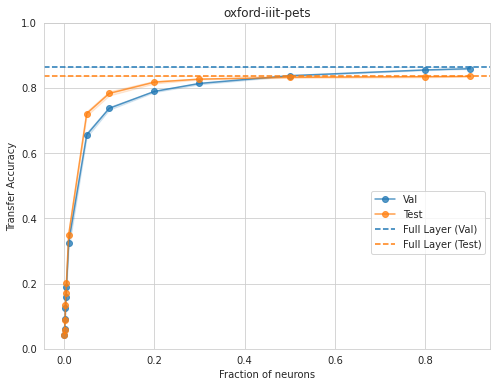

Global seed set to 2


oxford-iiit-pets {0.0005: [0.045089587569236755, 0.04245499521493912, 0.038943614810705185, 0.04593948274850845, 0.04573001340031624], 0.001: [0.06291751563549042, 0.061183761805295944, 0.05006156116724014, 0.06931541860103607, 0.056850798428058624], 0.002: [0.09594443440437317, 0.08386974036693573, 0.09413142502307892, 0.09558424353599548, 0.08995909988880157], 0.003: [0.13256269693374634, 0.13077020645141602, 0.12537223100662231, 0.13186636567115784, 0.11023904383182526], 0.004: [0.14109840989112854, 0.17126712203025818, 0.15814226865768433, 0.1646314561367035, 0.15563787519931793], 0.005: [0.18685957789421082, 0.19816789031028748, 0.18949416279792786, 0.19604915380477905, 0.17546138167381287], 0.01: [0.3124738335609436, 0.33825719356536865, 0.33414924144744873, 0.2920806407928467, 0.35142308473587036], 0.05: [0.6637383699417114, 0.6440904140472412, 0.6644255518913269, 0.6538354754447937, 0.6536514759063721], 0.1: [0.7291228175163269, 0.7418556213378906, 0.7418534755706787, 0.7379267

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'neuron_indices': tensor([1061])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ..., 1196,  674,  997])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ...,  522, 1270,  719])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=10, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ..., 1357, 1453, 1455])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'neuron_indices': tensor([1192])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161,  

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ...,  991,  983,  856])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ...,  662, 1879,  760])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ..., 1646,  183,  570])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2048, out_features=10, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ...,  637, 1922, 1063])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'neuron_indices': tensor([1898])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=10, bias=True))]), 'neuron_indices': tensor([1898,  578])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

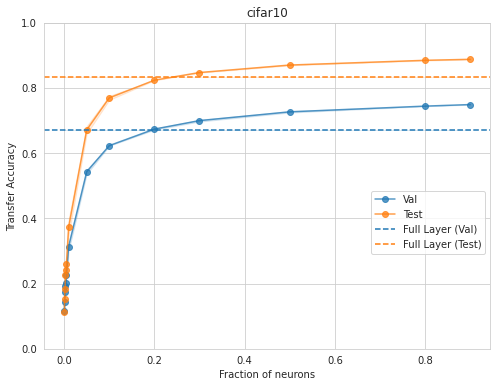

Global seed set to 2


cifar10 {0.0005: [0.11954693496227264, 0.1268082857131958, 0.10528450459241867], 0.001: [0.13647064566612244, 0.14354825019836426, 0.1489540934562683], 0.002: [0.16791069507598877, 0.1790148913860321], 0.003: [0.1794070303440094, 0.20845501124858856], 0.004: [0.19186079502105713, 0.21354931592941284], 0.005: [0.21204370260238647, 0.24017570912837982], 0.01: [0.326407253742218, 0.30084556341171265], 0.05: [0.5496917963027954, 0.5356155633926392], 0.1: [0.62376868724823, 0.6221764087677002], 0.2: [0.6715943813323975, 0.6756081581115723], 0.3: [0.6966792345046997, 0.7024934887886047], 0.5: [0.7243591547012329, 0.7287155985832214], 0.8: [0.7444778680801392, 0.7436667680740356], 0.9: [0.7484902143478394, 0.749165415763855]}


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'neuron_indices': tensor([1061])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=100, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=100, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=100, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2048, out_features=100, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ...,  637, 1922, 1063])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

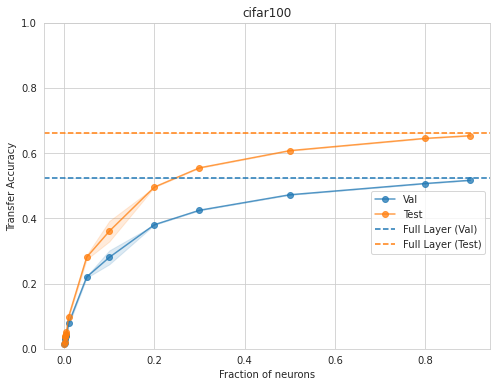

Global seed set to 2


cifar100 {0.0005: [0.011769605800509453, 0.017835237085819244], 0.001: [0.014627351425588131, 0.022320307791233063], 0.002: [0.027539480477571487, 0.032077398151159286], 0.003: [0.029130998998880386, 0.036612048745155334], 0.004: [0.03260248154401779, 0.043986983597278595], 0.005: [0.03846795856952667, 0.04423993453383446], 0.01: [0.07263638079166412, 0.08295067399740219], 0.05: [0.22275617718696594, 0.21779648959636688], 0.1: [0.3014412522315979, 0.2590399980545044], 0.2: [0.3803704082965851], 0.3: [0.4247247278690338], 0.5: [0.4722212553024292], 0.8: [0.5067257881164551], 0.9: [0.5166720151901245]}


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([1061])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ..., 1196,  674,  997])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ...,  522, 1270,  719])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=102, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ..., 1357, 1453, 1455])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([1192])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ...,  991,  983,  856])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ...,  662, 1879,  760])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ..., 1646,  183,  570])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2048, out_features=102, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ...,  637, 1922, 1063])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([1898])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848, 1760, 1483, 2047, 1104,
         592, 1511, 1945,  473, 1382, 1750,  580,  829, 1980, 1926, 1035, 1447,
        1781, 1141,  220, 1730, 1501, 1652,  438,  563,  462,  410,  794, 1756,
        1745, 1387, 1213,  658,  317, 1187,  418, 1526, 1973, 1117,  954,  325,
        1524,  668,   55, 1475,  320, 1440, 1544, 1011,  831, 1651,  332,  457,
          79,  290,  943, 1805, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848, 1760, 1483, 2047, 1104,
         592, 1511, 1945,  473, 1382, 1750,  580,  829, 1980, 1926, 1035, 1447,
        1781, 1141,  220, 1730, 1501, 1652,  438,  563,  462,  410,  794, 1756,
        1745, 1387, 1213,  658,  317, 1187,  418, 1526, 1973, 1117,  954,  325,
        1524,  668,   55, 1475,  320, 1440, 1544, 1011,  831, 1651,  332,  457,
          79,  290,  943, 1805, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848, 1760, 1483, 2047, 1104,
         592, 1511, 1945,  473, 1382, 1750,  580,  829, 1980, 1926, 1035, 1447,
        1781, 1141,  220, 1730, 1501, 1652,  438,  563,  462,  410,  794, 1756,
        1745, 1387, 1213,  658,  317, 1187,  418, 1526, 1973, 1117,  954,  325,
        1524,  668,   55, 1475,  320, 1440, 1544, 1011,  831, 1651,  332,  457,
          79,  290,  943, 1805, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848, 1760, 1483, 2047, 1104,
         592, 1511, 1945,  473, 1382, 1750,  580,  829, 1980, 1926, 1035, 1447,
        1781, 1141,  220, 1730, 1501, 1652,  438,  563,  462,  410,  794, 1756,
        1745, 1387, 1213,  658,  317, 1187,  418, 1526, 1973, 1117,  954,  325,
        1524,  668,   55, 1475,  320, 1440, 1544, 1011,  831, 1651,  332,  457,
          79,  290,  943, 1805, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669,  ...,  508, 1269, 1685])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669,  ...,  452,  466, 1714])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=102, bias=True))]), 'neuron_indices': tensor([1898,  578,  669,  ..., 1624, 1083,   66])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([1146])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181, 1314, 1264,  938, 1662,
         834,  926,  859, 1417, 1827,  540, 1983,  948,  710,  410, 1672, 1043,
         818, 1198, 1493, 1802,  544, 1698, 1638, 1327, 1699, 1633, 1280, 1218,
        1866, 1828, 2001,  337, 1098, 1331, 1902,  170, 1850,  599,  405, 1739,
        1411, 1458, 1925, 1115, 1745,   42, 1277, 1310,  709,  273, 2008, 1637,
         311,  290,  832,  785, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181, 1314, 1264,  938, 1662,
         834,  926,  859, 1417, 1827,  540, 1983,  948,  710,  410, 1672, 1043,
         818, 1198, 1493, 1802,  544, 1698, 1638, 1327, 1699, 1633, 1280, 1218,
        1866, 1828, 2001,  337, 1098, 1331, 1902,  170, 1850,  599,  405, 1739,
        1411, 1458, 1925, 1115, 1745,   42, 1277, 1310,  709,  273, 2008, 1637,
         311,  290,  832,  785, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181, 1314, 1264,  938, 1662,
         834,  926,  859, 1417, 1827,  540, 1983,  948,  710,  410, 1672, 1043,
         818, 1198, 1493, 1802,  544, 1698, 1638, 1327, 1699, 1633, 1280, 1218,
        1866, 1828, 2001,  337, 1098, 1331, 1902,  170, 1850,  599,  405, 1739,
        1411, 1458, 1925, 1115, 1745,   42, 1277, 1310,  709,  273, 2008, 1637,
         311,  290,  832,  785, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181, 1314, 1264,  938, 1662,
         834,  926,  859, 1417, 1827,  540, 1983,  948,  710,  410, 1672, 1043,
         818, 1198, 1493, 1802,  544, 1698, 1638, 1327, 1699, 1633, 1280, 1218,
        1866, 1828, 2001,  337, 1098, 1331, 1902,  170, 1850,  599,  405, 1739,
        1411, 1458, 1925, 1115, 1745,   42, 1277, 1310,  709,  273, 2008, 1637,
         311,  290,  832,  785, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87,  ...,  704,  766, 1596])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87,  ...,  231, 1078,  854])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=102, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87,  ...,  643, 1368, 1454])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([867])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530, 1241, 1320, 1572,  932,
        1524, 1775, 1821,  515, 2011,  791,  206, 1714, 1885,  942, 1980,  629,
         437, 1519,  493,  977,  686, 1081, 1672, 1725,   52,  642, 1011, 1405,
           6,  936,  782,  144, 1300, 1072, 1671,  498, 1239, 1709, 1314, 1551,
          97, 1795,  705, 1578, 1841,  475, 1251,  423, 1844, 1635,  190,  537,
         795,  589,  335,  259, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530, 1241, 1320, 1572,  932,
        1524, 1775, 1821,  515, 2011,  791,  206, 1714, 1885,  942, 1980,  629,
         437, 1519,  493,  977,  686, 1081, 1672, 1725,   52,  642, 1011, 1405,
           6,  936,  782,  144, 1300, 1072, 1671,  498, 1239, 1709, 1314, 1551,
          97, 1795,  705, 1578, 1841,  475, 1251,  423, 1844, 1635,  190,  537,
         795,  589,  335,  259, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530, 1241, 1320, 1572,  932,
        1524, 1775, 1821,  515, 2011,  791,  206, 1714, 1885,  942, 1980,  629,
         437, 1519,  493,  977,  686, 1081, 1672, 1725,   52,  642, 1011, 1405,
           6,  936,  782,  144, 1300, 1072, 1671,  498, 1239, 1709, 1314, 1551,
          97, 1795,  705, 1578, 1841,  475, 1251,  423, 1844, 1635,  190,  537,
         795,  589,  335,  259, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530, 1241, 1320, 1572,  932,
        1524, 1775, 1821,  515, 2011,  791,  206, 1714, 1885,  942, 1980,  629,
         437, 1519,  493,  977,  686, 1081, 1672, 1725,   52,  642, 1011, 1405,
           6,  936,  782,  144, 1300, 1072, 1671,  498, 1239, 1709, 1314, 1551,
          97, 1795,  705, 1578, 1841,  475, 1251,  423, 1844, 1635,  190,  537,
         795,  589,  335,  259, 

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  ...,  459, 2016,  221])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  ..., 1362,  875, 1374])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=102, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  ..., 1000,  284,  776])}


Predicting: 0it [00:00, ?it/s]

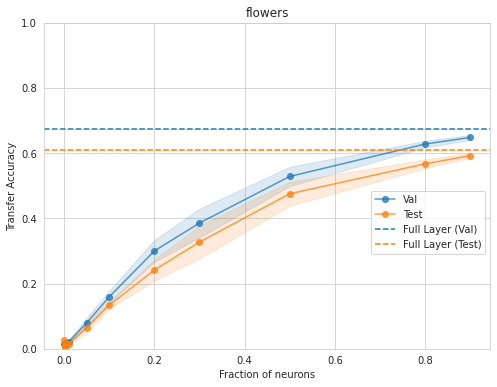

Global seed set to 2


flowers {0.0005: [0.016190174967050552, 0.010803703218698502, 0.018608514219522476, 0.015186700969934464, 0.011768731288611889], 0.001: [0.011303518898785114, 0.012272391468286514, 0.011307363398373127, 0.010311576537787914, 0.011780265718698502], 0.002: [0.01572880893945694, 0.012283925898373127, 0.008839043788611889, 0.012283924967050552, 0.014725332148373127], 0.003: [0.010769100859761238, 0.02007720246911049, 0.017628107219934464, 0.013706477358937263, 0.02006566897034645], 0.004: [0.0161747969686985, 0.013225886039435863, 0.027428336441516876, 0.020584706217050552, 0.0191044844686985], 0.005: [0.025990404188632965, 0.016163263469934464, 0.018635425716638565, 0.015690360218286514, 0.014706108719110489], 0.01: [0.011265071108937263, 0.022510919719934464, 0.020115649327635765, 0.020588552579283714, 0.03185746818780899], 0.05: [0.07545290887355804, 0.10390779376029968, 0.07938607037067413, 0.056394562125205994, 0.0842919573187828], 0.1: [0.17691545188426971, 0.18575064837932587, 0.149

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([1061])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250, 1136,  707,   96,  697, 1023,  727, 1780,  534,  563,
         480, 1316,  873,  929, 1062, 1679,  260, 1337,  818, 1238, 1430, 1452,
        1323, 1661,  750,  989,  217,  228,  498,   35, 1847, 1786,  453, 2036,
        1179,  173,  400, 1548, 1893,  766, 1191, 1221, 1751, 1523,  512,  128,
         769,  259,  566,  678,   47, 1493, 1801, 1781, 1543, 1833,  125, 1088,
         182,  163, 1265, 1396,  533, 1634, 2045,  508, 1680, 1971, 1599,  667,
         812,  315,  798,  111,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ..., 1196,  674,  997])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ...,  522, 1270,  719])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=37, bias=True))]), 'neuron_indices': tensor([1061, 1497, 1250,  ..., 1357, 1453, 1455])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([1192])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799, 1387, 1198,  827, 1450,  283,  688, 1500, 1142,  147,
        1723, 2003,  683, 1148, 1247,  580,  274,   62,  696,  512,  729, 1384,
         531,  918, 1446, 1979, 2027, 1746,  687, 1340,  490, 1009, 1282,  361,
         347, 1296,  871, 1050, 1996,  864,  748, 1955, 1255, 1119, 1015, 1669,
        1968,  447,    4, 1171, 1530,  746,  402, 1299, 2031, 1605,  723,   40,
        1558, 1486,  740,  882, 1658,  127, 1685,  734,  184,  300, 1243, 1635,
        1528,  320, 1875,  161,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ...,  991,  983,  856])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ...,  662, 1879,  760])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ..., 1646,  183,  570])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2048, out_features=37, bias=True))]), 'neuron_indices': tensor([1192, 1790,  799,  ...,  637, 1922, 1063])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([1898])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848, 1760, 1483, 2047, 1104,
         592, 1511, 1945,  473, 1382, 1750,  580,  829, 1980, 1926, 1035, 1447,
        1781, 1141,  220, 1730, 1501, 1652,  438,  563,  462,  410,  794, 1756,
        1745, 1387, 1213,  658,  317, 1187,  418, 1526, 1973, 1117,  954,  325,
        1524,  668,   55, 1475,  320, 1440, 1544, 1011,  831, 1651,  332,  457,
          79,  290,  943, 1805,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848, 1760, 1483, 2047, 1104,
         592, 1511, 1945,  473, 1382, 1750,  580,  829, 1980, 1926, 1035, 1447,
        1781, 1141,  220, 1730, 1501, 1652,  438,  563,  462,  410,  794, 1756,
        1745, 1387, 1213,  658,  317, 1187,  418, 1526, 1973, 1117,  954,  325,
        1524,  668,   55, 1475,  320, 1440, 1544, 1011,  831, 1651,  332,  457,
          79,  290,  943, 1805,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848, 1760, 1483, 2047, 1104,
         592, 1511, 1945,  473, 1382, 1750,  580,  829, 1980, 1926, 1035, 1447,
        1781, 1141,  220, 1730, 1501, 1652,  438,  563,  462,  410,  794, 1756,
        1745, 1387, 1213,  658,  317, 1187,  418, 1526, 1973, 1117,  954,  325,
        1524,  668,   55, 1475,  320, 1440, 1544, 1011,  831, 1651,  332,  457,
          79,  290,  943, 1805,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669, 1890,  704,  404, 1786,  425,  429,  139, 1894, 1529,
        1609,  347,  626,  229,  903, 1808,  598, 1848, 1760, 1483, 2047, 1104,
         592, 1511, 1945,  473, 1382, 1750,  580,  829, 1980, 1926, 1035, 1447,
        1781, 1141,  220, 1730, 1501, 1652,  438,  563,  462,  410,  794, 1756,
        1745, 1387, 1213,  658,  317, 1187,  418, 1526, 1973, 1117,  954,  325,
        1524,  668,   55, 1475,  320, 1440, 1544, 1011,  831, 1651,  332,  457,
          79,  290,  943, 1805,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669,  ...,  508, 1269, 1685])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669,  ...,  452,  466, 1714])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=37, bias=True))]), 'neuron_indices': tensor([1898,  578,  669,  ..., 1624, 1083,   66])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([1146])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181, 1314, 1264,  938, 1662,
         834,  926,  859, 1417, 1827,  540, 1983,  948,  710,  410, 1672, 1043,
         818, 1198, 1493, 1802,  544, 1698, 1638, 1327, 1699, 1633, 1280, 1218,
        1866, 1828, 2001,  337, 1098, 1331, 1902,  170, 1850,  599,  405, 1739,
        1411, 1458, 1925, 1115, 1745,   42, 1277, 1310,  709,  273, 2008, 1637,
         311,  290,  832,  785,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181, 1314, 1264,  938, 1662,
         834,  926,  859, 1417, 1827,  540, 1983,  948,  710,  410, 1672, 1043,
         818, 1198, 1493, 1802,  544, 1698, 1638, 1327, 1699, 1633, 1280, 1218,
        1866, 1828, 2001,  337, 1098, 1331, 1902,  170, 1850,  599,  405, 1739,
        1411, 1458, 1925, 1115, 1745,   42, 1277, 1310,  709,  273, 2008, 1637,
         311,  290,  832,  785,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181, 1314, 1264,  938, 1662,
         834,  926,  859, 1417, 1827,  540, 1983,  948,  710,  410, 1672, 1043,
         818, 1198, 1493, 1802,  544, 1698, 1638, 1327, 1699, 1633, 1280, 1218,
        1866, 1828, 2001,  337, 1098, 1331, 1902,  170, 1850,  599,  405, 1739,
        1411, 1458, 1925, 1115, 1745,   42, 1277, 1310,  709,  273, 2008, 1637,
         311,  290,  832,  785,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87, 1321, 1741, 1387, 1081, 1563, 1250, 1187,  300, 1906,
         199, 1576, 1494,  602, 1975, 1614,  148,  181, 1314, 1264,  938, 1662,
         834,  926,  859, 1417, 1827,  540, 1983,  948,  710,  410, 1672, 1043,
         818, 1198, 1493, 1802,  544, 1698, 1638, 1327, 1699, 1633, 1280, 1218,
        1866, 1828, 2001,  337, 1098, 1331, 1902,  170, 1850,  599,  405, 1739,
        1411, 1458, 1925, 1115, 1745,   42, 1277, 1310,  709,  273, 2008, 1637,
         311,  290,  832,  785,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87,  ...,  704,  766, 1596])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87,  ...,  231, 1078,  854])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=37, bias=True))]), 'neuron_indices': tensor([1146, 1581,   87,  ...,  643, 1368, 1454])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([867])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530, 1241, 1320, 1572,  932,
        1524, 1775, 1821,  515, 2011,  791,  206, 1714, 1885,  942, 1980,  629,
         437, 1519,  493,  977,  686, 1081, 1672, 1725,   52,  642, 1011, 1405,
           6,  936,  782,  144, 1300, 1072, 1671,  498, 1239, 1709, 1314, 1551,
          97, 1795,  705, 1578, 1841,  475, 1251,  423, 1844, 1635,  190,  537,
         795,  589,  335,  259,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530, 1241, 1320, 1572,  932,
        1524, 1775, 1821,  515, 2011,  791,  206, 1714, 1885,  942, 1980,  629,
         437, 1519,  493,  977,  686, 1081, 1672, 1725,   52,  642, 1011, 1405,
           6,  936,  782,  144, 1300, 1072, 1671,  498, 1239, 1709, 1314, 1551,
          97, 1795,  705, 1578, 1841,  475, 1251,  423, 1844, 1635,  190,  537,
         795,  589,  335,  259,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530, 1241, 1320, 1572,  932,
        1524, 1775, 1821,  515, 2011,  791,  206, 1714, 1885,  942, 1980,  629,
         437, 1519,  493,  977,  686, 1081, 1672, 1725,   52,  642, 1011, 1405,
           6,  936,  782,  144, 1300, 1072, 1671,  498, 1239, 1709, 1314, 1551,
          97, 1795,  705, 1578, 1841,  475, 1251,  423, 1844, 1635,  190,  537,
         795,  589,  335,  259,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  878, 1774,  921,  464, 1591,  536, 1652, 1757, 1928,
         311, 1450, 1076, 1564, 1687, 1403, 1445, 1530, 1241, 1320, 1572,  932,
        1524, 1775, 1821,  515, 2011,  791,  206, 1714, 1885,  942, 1980,  629,
         437, 1519,  493,  977,  686, 1081, 1672, 1725,   52,  642, 1011, 1405,
           6,  936,  782,  144, 1300, 1072, 1671,  498, 1239, 1709, 1314, 1551,
          97, 1795,  705, 1578, 1841,  475, 1251,  423, 1844, 1635,  190,  537,
         795,  589,  335,  259,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  ...,  459, 2016,  221])}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  ..., 1362,  875, 1374])}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=37, bias=True))]), 'neuron_indices': tensor([ 867, 1296, 2037,  ..., 1000,  284,  776])}


Predicting: 0it [00:00, ?it/s]

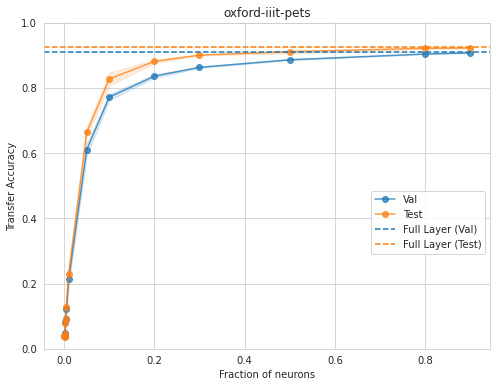

oxford-iiit-pets {0.0005: [0.03469768911600113, 0.058588091284036636, 0.03629273921251297, 0.0309605710208416, 0.04168223589658737], 0.001: [0.030226025730371475, 0.055158089846372604, 0.039285410195589066, 0.03873626887798309, 0.03450449928641319], 0.002: [0.028879359364509583, 0.0738663375377655, 0.05397772043943405, 0.047850146889686584, 0.041157156229019165], 0.003: [0.0827813595533371, 0.10337692499160767, 0.06356431543827057, 0.06623782962560654, 0.09170912951231003], 0.004: [0.07443670928478241, 0.12382034212350845, 0.08565443754196167, 0.08386194705963135, 0.09312938898801804], 0.005: [0.12067269533872604, 0.146384596824646, 0.13172341883182526, 0.10493730008602142, 0.10999277979135513], 0.01: [0.2339957058429718, 0.22673234343528748, 0.2207576036453247, 0.19179333746433258, 0.19447535276412964], 0.05: [0.6108617782592773, 0.6254861354827881, 0.6365283727645874, 0.5820227861404419, 0.5974722504615784], 0.1: [0.7790336608886719, 0.7696975469589233, 0.7826730608940125, 0.77029973

In [5]:
plt_str = '== Finetuning results ==\n\n'
for append in APPENDS:
    plt_str += f'=== {append} ===\n\n'
    for ft_ds in FINETUNING_DATASETS:
        plt_str += f'==== {ft_ds} ====\n\n'
        frac_wise_val_accs, frac_wise_test_accs = {}, {}
        for seed in PARTIAL_CHOICE_SEEDS:
            for frac in PARTIAL_FRACTIONS:
                model_path = glob.glob(f'{BASE_DIR}/{MODEL}-base-{SOURCE_DATASET}-ft-{ft_ds}/'
                                       f'frac-{frac:.5f}-mode-{FINETUNE_MODE}-seed-{seed}-lr-*-bs*/'
                                       f'{append}/'
                                       '*-topk=1.ckpt')
                if len(model_path) == 0:
                    continue
                model_path = model_path[0]
                
                sd = torch.load(model_path)
                
                if frac in frac_wise_val_accs:
                    frac_wise_val_accs[frac].append(list(sd['callbacks'].values())[0]['best_model_score'].item())
                    frac_wise_test_accs[frac].append(
                        get_test_acc(ft_ds, CHECKPOINT_PATHS[append], sd, seed, frac))
                else:
                    frac_wise_val_accs[frac] = [list(sd['callbacks'].values())[0]['best_model_score'].item()]
                    frac_wise_test_accs[frac] = [
                        get_test_acc(ft_ds, CHECKPOINT_PATHS[append], sd, seed, frac)]

        full_acc_val, full_acc_test = frac_wise_val_accs.pop(1.), frac_wise_test_accs.pop(1.)
        x_vals, y_vals = list(zip(*sorted(frac_wise_val_accs.items(), key=lambda t: t[0])))
        _, y_tests = list(zip(*sorted(frac_wise_test_accs.items(), key=lambda t: t[0])))
        plt_str += '{}\n\n'.format(plt_hp.get_wiki_link(plt_hp.line_plot(
            [[np.mean(_y) for _y in y_vals], [np.mean(_y) for _y in y_tests]], 
            'Fraction of neurons', 'Transfer Accuracy', ft_ds, 
            subfolder=SOURCE_DATASET, filename=f'{MODEL}_{ft_ds}_bs_{FINETUNE_BS}_{append}', 
            extension='png', x_vals=x_vals, 
            legend_vals=['Val', 'Test', 'Full Layer (Val)', 'Full Layer (Test)'], 
            vertical_line=None, horizontal_lines=[np.mean(full_acc_val), np.mean(full_acc_test)], 
            horizontal_lines_err=[np.std(full_acc_val), np.std(full_acc_test)], 
            colors=[plt_hp.COLORS[0], plt_hp.COLORS[1], plt_hp.COLORS[0], plt_hp.COLORS[1]], 
            linestyles=['-', '-', ':', ':'], y_lims=(0.,1.), root_dir='.', 
            paper_friendly_plots=False, plot_inside=False, legend_location='best', 
            savefig=True, figsize=(10,6), marker=[True, True, False, False], 
            results_subfolder_name='transfer_analysis', grid_spacing=None, 
            y_err=[[np.std(_y) for _y in y_vals], [np.std(_y) for _y in y_tests]], 
            legend_ncol=None), SERVER_PROJECT_PATH, size=700))

        print (ft_ds, frac_wise_val_accs)

In [6]:
with open(f'./results/transfer_analysis/{SOURCE_DATASET}/wiki_results.txt', 'w') as fp:
    fp.write(plt_str)

In [7]:
out.upload_results(['{}/{}/{}'.format(plt_hp.RESULTS_FOLDER_NAME, 'transfer_analysis', SOURCE_DATASET)], 
        'results', SERVER_PROJECT_PATH, '.png')

Uploading results in ['results/transfer_analysis/imagenet'] to contact.mpi-sws.org...
Uploading 12 files to server
copying results/transfer_analysis/imagenet/resnet50_cifar10_bs_256_robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/transfer_analysis/imagenet/resnet50_cifar10_bs_256_robustl2eps3.png
copying results/transfer_analysis/imagenet/resnet50_cifar100_bs_256_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/transfer_analysis/imagenet/resnet50_cifar100_bs_256_nonrob.png
copying results/transfer_analysis/imagenet/resnet50_flowers_bs_256_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/transfer_analysis/imagenet/resnet50_flowers_bs_256_nonrob.png
copying results/transfer_analysis/imagenet/resnet50_oxford-iiit-pets_bs_256_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/transfer_analysis/imagenet/resnet50_oxford-iiit-pets_bs_256_nonrob.png
copying results/transfer_analysis/imagenet/resnet50_c